## Trabalho 1 — INF-0618 Deep Learning   


Alunos:
- Vitor de Oliveira Fernandez Araujo
- Vitor Sancho Cardoso

Neste trabalho, vamos utilizar o conjunto de dados GeoDE. Este conjunto de dados possui imagens de objetos comuns, fotografados em diferentes lugares do mundo, por diferentes voluntários. O conjunto original possui imagens de diversos tamanhos e 40 objetos diferentes, fotografados em 6 regiões diferentes do planeta.

A ideia do conjunto é ser inclusivo com as diferentes sociedades. Um fogão na Europa é igual ao da Índia? Muitas vezes não. O artigo deste conjunto de dados, publicado [neste link](https://geodiverse-data-collection.cs.princeton.edu/), demonstra que modelos treinados no conjunto de dados da ImageNet tem uma queda de performance consideravel ao serem testados em objetos de outras localidades, mas que teoricamente o modelo já conhecia.

Neste trabalho iremos trabalhar com um subconjunto desse conjunto de dados, para limitar a quantidade de hardware necessário, usando apenas 4 classes. Além disso, todas as imagens foram previamente redimensionadas para a resolução de 300x400, e disponibilizadas em uma pasta compartilhada no google drive ([neste link](https://drive.google.com/drive/folders/1OYDEVPH52LF0Z4hg5uq3LnvsWB61_5zA?usp=sharing)). Para utilizar os dados no Google Colab, é necessário criar um atalho dessa pasta para o seu Google Drive (ao acessar a pasta, tem uma seta para baixo perto do nome da pasta > organizar > adicionar atalho).

O dataset reduzido é composto por 7768 imagens, distribuídas por classes da seguinte maneira:
- Car: 1721 amostras
- House: 1510 amostras
- Bag: 2362 amostras
- Chair: 2175 amostras

![Classes do dataset ](figures/classes_geode.png)


## Importando bibliotecas

Todas já estão instaladas no Google Colab. Caso localmente algum import falhe, a biblioteca específica deve ser instalada.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Baixar e carregar os dados

Os dados estão no [link do drive](https://drive.google.com/drive/folders/1OYDEVPH52LF0Z4hg5uq3LnvsWB61_5zA?usp=sharing), na pasta "GeoDE_tf".

Para rodar localmente, o dataset deve ser baixado e colocado na mesma pasta deste notebook.

As células abaixo demonstram como rodar no Google Colab, primeiro montando o drive, e então copiando o dataset para o ambiente atual (isso aumenta MUITO a velocidade de acesso de dados, pois o drive é mais lento).

In [7]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
# O primeiro caminho é o local dentro do seu drive que o dataset aparecerá (no caso, em shared drives),
# e o segundo o nome do dataset utilizado nas próximas células
# Esse comando só funcionará se o atalho da pasta foi corretamente adicionado ao seu Drive
!cp -r drive/MyDrive/GeoDE_tf/ GeoDE_tf/

# Comando original abaixo (tive que mudar, pois criei o atalho direto para a pasta do dataset)
# !cp -r drive/MyDrive/MDC_Datasets/GeoDE_tf/ GeoDE_tf/

## Carregando e pré processando o dataset


In [9]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pathlib
import numpy as np

# --- Configuration ---
DATASET_DIR = "GeoDE_tf/"
IMAGE_WIDTH = 200
IMAGE_HEIGHT = 200
BATCH_SIZE = 256
SEED = 42
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406])
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225])
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

In [10]:
@tf.function
def imagenet_normalize(image, label):
  """
  Transforma as imagens para o intervalo [0, 1], que facilita o treinamento.
  Além disso, normaliza os dados de acordo com a média e desvio do dataset ImageNet.
  Isso é costume ao processar imagens naturais normalizadas.
  """
  # Transformar para [0,1]
  image = tf.cast(image, tf.float32) / 255.0

  # Fazer a normalização
  mean = tf.reshape(IMAGENET_MEAN, [1, 1, 3])
  std = tf.reshape(IMAGENET_STD, [1, 1, 3])
  image = (image - mean) / std

  return image, label

In [11]:
def load_and_split_dataset(data_dir, img_height, img_width, batch_size, seed):
  """
  Carrega o dataset a partir da pasta em "data_dir"
  Os rotulos sao inferidos pelo nome das pastas, e separados em treino,
    validacao e teste (60-20-20).
  Alem disso, as imagens sao redimensionadas de acordo com img_height e img_width.

  Os datasets sao retornados ja em batches, de forma a diminuir consumo de memoria.

  Retorna os datasets de treino, validacao e teste, e o nome das classes encontradas.
  """
  data_dir = pathlib.Path(data_dir)
  image_count = len(list(data_dir.glob('*/*.png')))

  if image_count == 0:
    raise ValueError(f"Nenhuma imagem em {data_dir}. Verifique o caminho da pasta.")

  # Treino (60% dados)
  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.4,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
  )

  # Pega os 40% restantes para validacao e teste
  val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.4,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
  )

  class_names = train_ds.class_names

  # Para separar validacao e teste, precisamos fazer por batches
  total_val_batches = tf.data.experimental.cardinality(val_test_ds).numpy()

  # Separa em 2
  val_ds = val_test_ds.take(total_val_batches // 2)
  test_ds = val_test_ds.skip(total_val_batches // 2)

  print(f"\nTotal de imagens: {image_count}")
  print(f"Classes: {class_names}")
  print(f"Batches de treino: {tf.data.experimental.cardinality(train_ds).numpy()}")
  print(f"Batches de validacao: {tf.data.experimental.cardinality(val_ds).numpy()}")
  print(f"Batches de teste: {tf.data.experimental.cardinality(test_ds).numpy()}")

  # Agora aplicamos a normalizacao nos tres conjuntos
  AUTOTUNE = tf.data.AUTOTUNE
  train_ds = train_ds.map(imagenet_normalize, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.map(imagenet_normalize, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
  test_ds = test_ds.map(imagenet_normalize, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

  return train_ds, val_ds, test_ds, class_names

In [12]:
train_ds, val_ds, test_ds, class_names = load_and_split_dataset(
        DATASET_DIR, IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, SEED
    )

Found 7772 files belonging to 4 classes.
Using 4664 files for training.
Found 7772 files belonging to 4 classes.
Using 3108 files for validation.

Total de imagens: 7767
Classes: ['bag', 'car', 'chair', 'house']
Batches de treino: 19
Batches de validacao: 6
Batches de teste: 7


In [13]:
NUM_CLASSES = len(class_names)
NUM_CLASSES

4

In [14]:
from sklearn.utils.class_weight import compute_class_weight

all_train_labels = []
for _, labels in train_ds.unbatch():
    all_train_labels.append(int(labels.numpy()))
all_train_labels = np.array(all_train_labels)

classes = np.arange(NUM_CLASSES)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=all_train_labels)
train_class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
del all_train_labels

## Funções Auxiliares

In [15]:
def plot_loss_accuracy(history, title='Treino'):
  # Implemente aqui
  """
  history: objeto retornado por model.fit (ou dicionário com keys 'loss','val_loss','accuracy','val_accuracy')
  """
  if hasattr(history, 'history'):
      hist = history.history
  else:
      hist = history

  epochs = range(1, len(hist['loss']) + 1)
  full_range = range(1,31)

  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(epochs, hist['loss'], label='train loss')
  plt.plot(epochs, hist.get('val_loss', []), label='val loss')
  plt.xlabel('Época')
  plt.ylabel('Loss')
  plt.xticks(full_range)
  plt.title(f'Loss - {title}')
  plt.legend()

  plt.subplot(1,2,2)
  # Nem sempre 'accuracy' existe (depende de compile). Ajusta com get.
  plt.plot(epochs, hist.get('accuracy', hist.get('acc', [])), label='train acc')
  plt.plot(epochs, hist.get('val_accuracy', hist.get('val_acc', [])), label='val acc')
  plt.xlabel('Época')
  plt.ylabel('Accuracy')
  plt.xticks(full_range)
  plt.title(f'Accuracy - {title}')
  plt.legend()
  plt.tight_layout()
  plt.show()

def plot_confusion_matrix(model, dataset, title='Treino', class_names=class_names):
    """
    Gera e exibe a matriz de confusão para o modelo e dataset fornecidos.

    Parâmetros:
      model: modelo Keras treinado
      dataset: dataset de validação
      class_names: lista de nomes das classes
    """
    # Extrai imagens e rótulos verdadeiros do dataset
    y_true = np.concatenate([y.numpy() for _, y in dataset], axis=0)

    # Faz previsões (logits)
    y_pred_logits = model.predict(dataset)
    y_pred = np.argmax(y_pred_logits, axis=1)

    # Calcula matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Exibe matriz
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

### Visualização dos dados

In [16]:
def plot_denormalized_images(dataset, class_names=class_names, n_row = 2, n_col = 6, figsize = (10, 8)):
  """
  Mostra imagens com rótulo, removendo a normalização antes do plot.
  Para mostrar mais/menos imagens, utilizem os parâmetros de n_row e n_col.
  """

  # Pega um batch de imagens do dataset
  images_batch, labels_batch = next(iter(dataset))

  # Converte para numpy
  images_np = images_batch.numpy()
  labels_np = labels_batch.numpy()

  # Seleciona algumas imagens para plotar
  n_images_to_plot = min(n_row * n_col, len(images_np))
  imgList = images_np[:n_images_to_plot]
  labels = labels_np[:n_images_to_plot]

  # Tira a normalização feita anteriormente
  mean = IMAGENET_MEAN.numpy().reshape(1, 1, 1, 3)
  std = IMAGENET_STD.numpy().reshape(1, 1, 1, 3)
  denormalized_images = (imgList * std) + mean
  denormalized_images = np.clip(denormalized_images * 255.0, 0, 255).astype(np.uint8)

  # Plot das imagens
  fig, axs = plt.subplots(n_row, n_col, figsize=figsize)
  axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

  for i, (img, ax) in enumerate(zip(denormalized_images, axs)):
      ax.imshow(img)

      if labels is not None and i < len(labels):
          label_idx = labels[i]
          if 0 <= label_idx < len(class_names):
              ax.set_title(class_names[label_idx], fontsize=10)
      ax.axis('off')

  # Remove os axes que não foram utilizados
  for ax in axs[len(denormalized_images):]:
      ax.axis('off')

  plt.tight_layout()
  plt.suptitle("Imagens do dataset (parte do primeiro batch)", fontsize=14)
  plt.show()

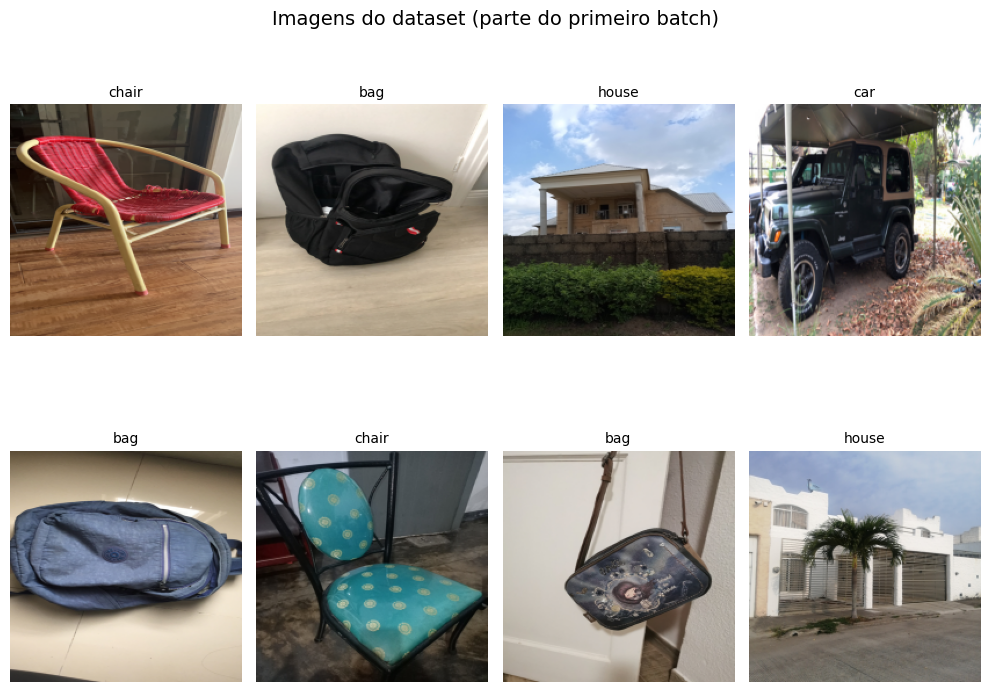

In [ ]:
plot_denormalized_images(
        dataset=train_ds,
        class_names=class_names,
        n_row=2,
        n_col=4,
    )

In [17]:
import tensorflow as tf
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
import json

file_root = 'drive/MyDrive/mdc_checkpoints/'

def build_checkpoint_file_name(model_name):
  return file_root+model_name+".keras"

def build_history_file_name(model_name):
  return file_root+model_name+"-history.json"

def train_or_load_model(model, model_name, epochs=30, callbacks=[], force_train=False):
  checkpoint_file = build_checkpoint_file_name(model_name)
  history_file = build_history_file_name(model_name)

  if not force_train and os.path.exists(checkpoint_file):
    print(f"Carregando dos arquivos {history_file} e {checkpoint_file}")
    try:
      model.load_weights(checkpoint_file)
      with open(history_file) as f:
        hist = json.load(f)
      return hist
    except:
      print("Erro ao recuperar modelos salvos! Retreinando...")

  history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    class_weight=train_class_weights,
    callbacks=callbacks
  )
  with open(history_file, "w") as f:
    json.dump(history.history, f)

  return history.history

## Atividade

Para cada questão proposta, descreva detalhadamente os experimentos realizados e apresente uma análise aprofundada dos resultados obtidos. É essencial criar gráficos que mostrem a relação entre a função de perda (loss) e o número de épocas, considerando os dados de treinamento e de validação para cada modelo. Além disso, apresente a matriz de confusão em termos relativos. Identificar sinais de  overfitting é crucial para avaliar a capacidade de generalização do modelo; portanto, baseando-se nos gráficos elaborados, discuta quaisquer indícios que possam sugerir que o modelo está se ajustando excessivamente aos dados de treinamento

Nota Importante: O conjunto de teste deve ser utilizado apenas uma vez, no final de todas as experimentações!

### Projeção e Treinamento de uma Rede Neural Convolucional Simples (Baseline)

1. (1.5) Projete e treine uma rede neural convolucional simples como modelo básico (baseline), construindo-a do zero sem utilizar arquiteturas pré-existentes. Por exemplo, você pode iniciar com uma arquitetura que contenha apenas uma ou duas camadas convolucionais e de pooling. Lembre-se: quanto mais simples for a arquitetura inicial, melhor será para avaliar o impacto de futuras melhorias.

In [ ]:
# Modelo baseline

baseline = "model-baseline"

checkpoint_cb = ModelCheckpoint(
    filepath=build_checkpoint_file_name(baseline),
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    save_weights_only=False,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=5,
    restore_best_weights=True
)

INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

model_base = tf.keras.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.Conv2D(10, 3, strides=(2,2), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model_base.compile(
    optimizer=tf.keras.optimizers.SGD(1e-2, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 99, 99, 10)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24010)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        96,044 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,324 (376.27 KB)

 Trainable params: 96,324 (376.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_base = train_or_load_model(model_base, baseline, epochs=30, callbacks=[checkpoint_cb, early_stopping])
model_base.evaluate(val_ds)

Carregando dos arquivos drive/MyDrive/mdc_checkpoints/model-baseline-history.json e drive/MyDrive/mdc_checkpoints/model-baseline.keras


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 722ms/step - accuracy: 0.6778 - loss: 0.9454


[0.9950728416442871, 0.6731770634651184]

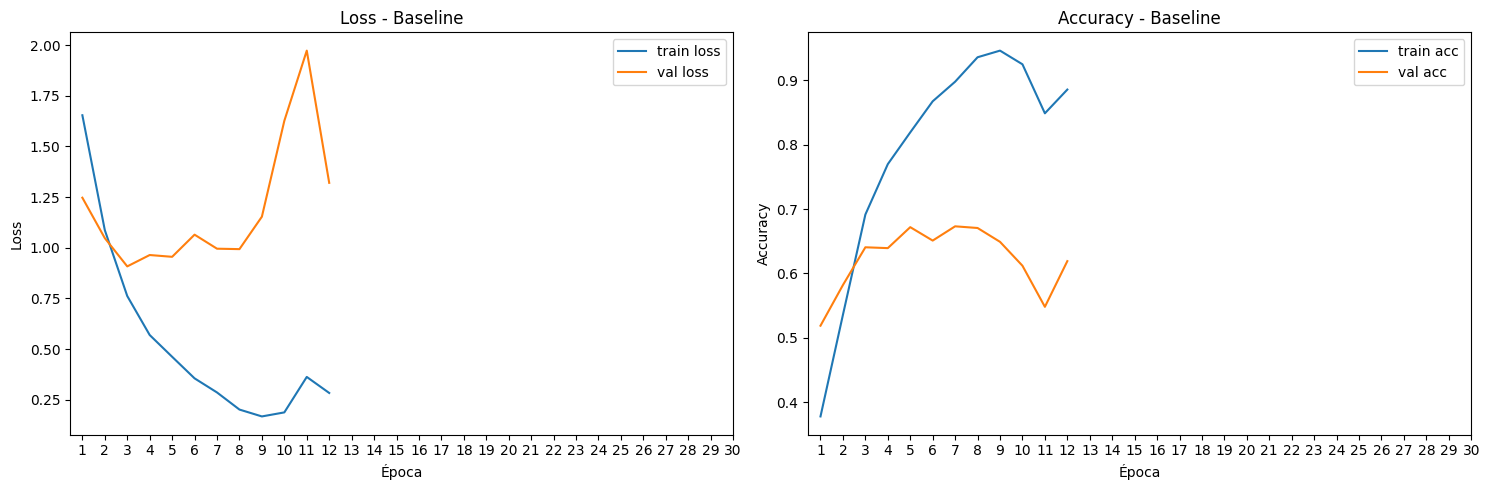

In [ ]:
plot_loss_accuracy(history_base, title='Baseline')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


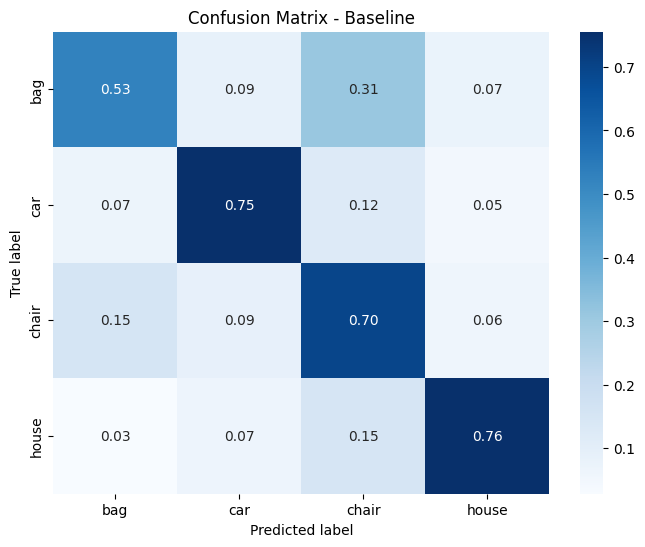

In [ ]:
plot_confusion_matrix(model_base, val_ds, title='Baseline')

In [ ]:
preds = model_base.predict(val_ds.take(1))[:5]
np.array(class_names)[np.argmax(preds, axis=1)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array(['bag', 'car', 'chair', 'chair', 'chair'], dtype='<U5')

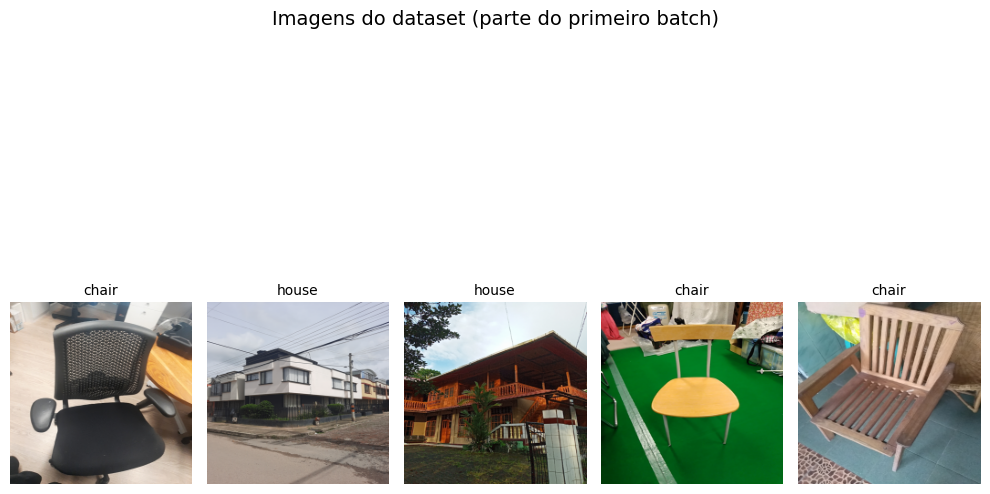

In [ ]:
plot_denormalized_images(val_ds.take(1), n_row=1, n_col=5)

##### Discussão:

Construímos nosso modelo baseline de forma simples, utilizando apenas uma camada convolucional com 10 filtros 3x3 e stride 2 (para diminuir a quantidade de parametros) e um MaxPooling 2x2, finalizando de maneira simples com um softmax já nas 4 classes alvo. Nesta configuração, conseguimos uma acurácia de 67.3%, utilizando uma taxa de aprendizado de 1e-2 com momento 0.9, além de balancear o treinamento, para compensar a distribuição de classes no dataset. Como utilizamos early stopping, o treinamento não chegou a realizar 30 épocas, mas é possível dizer que o modelo começa um processo de overfitting por volta da época 4, com a taxa de aumento da acurácia de validação diminuindo drasticamente em relação à de treinamento. Ao analisar a matriz de confusão, vemos que o maior erro do modelo acontece entre as classes 'chair' e 'bag', e os erros da classe 'car' bem distribuídos e relativamente elevados (~10%) ao longo das outras classes.

### Variação do Número de Camadas de Convolução e Pooling

2. (1.5) Explore o impacto de variar o número de camadas de convolução e pooling em **pelo menos duas** arquiteturas diferentes em relação ao modelo baseline. Ao construir essas arquiteturas, experimente diferentes funções de ativação, inicializações e regularizações, e considere o uso de dropout na camada totalmente conectada. Visite http://keras.io para descobrir quais funções de ativação e outros componentes estão disponíveis. Não se esqueça de plotar os gráficos da função de perda loss em relação ao número de épocas, tanto para o treino quanto para a validação de cada modelo. Tenha cuidado com o overfitting.


In [ ]:
# Modelo variante 1

m1_name = "model1"

checkpoint1 = ModelCheckpoint(
    filepath=build_checkpoint_file_name(m1_name),
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    save_weights_only=False,
    verbose=1
)

INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

model1 = tf.keras.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(10, 3, activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model1.compile(
    optimizer=tf.keras.optimizers.SGD(1e-2, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model1.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 198, 198, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 99, 99, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 97, 97, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 23040)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 512)            │    11,796,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,800,234 (45.01 MB)

 Trainable params: 11,800,234 (45.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history1 = train_or_load_model(model1, m1_name, epochs=30, callbacks=[checkpoint1, early_stopping])
model1.evaluate(val_ds)

Carregando dos arquivos drive/MyDrive/mdc_checkpoints/model1-history.json e drive/MyDrive/mdc_checkpoints/model1.keras


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7393 - loss: 1.1234


[1.183739185333252, 0.7220051884651184]

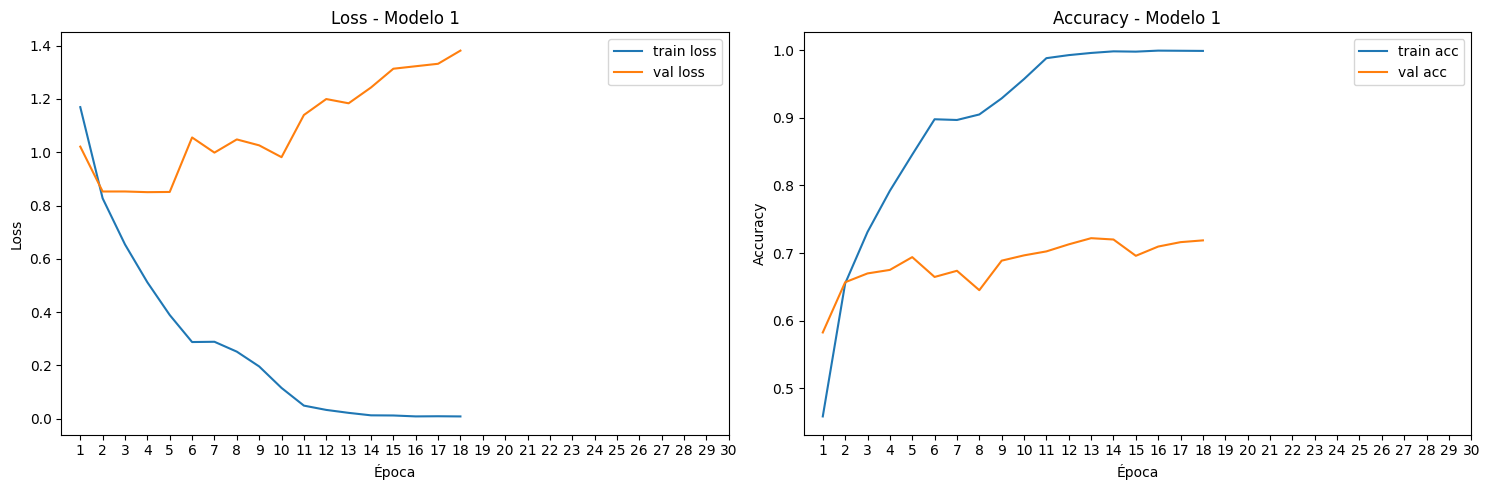

In [ ]:
plot_loss_accuracy(history1, title='Modelo 1')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


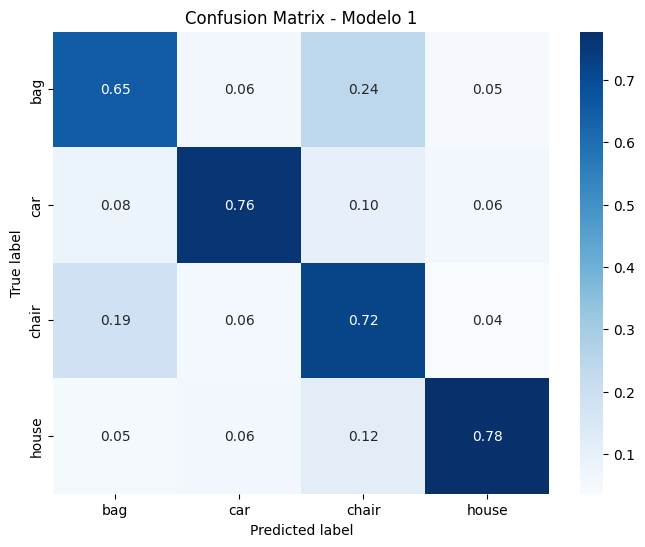

In [ ]:
plot_confusion_matrix(model1, val_ds, title='Modelo 1')

In [ ]:
# Modelo variante 2

m2_name = "model2"

checkpoint2 = ModelCheckpoint(
    filepath=build_checkpoint_file_name(m2_name),
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    save_weights_only=False,
    verbose=1
)

INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

model2 = tf.keras.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.Conv2D(50, 3, activation='relu'),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(50, 5, activation='relu'),
    layers.BatchNormalization(momentum=0.9),
    layers.MaxPooling2D((5,5)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model2.compile(
    optimizer=tf.keras.optimizers.SGD(1e-2, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 198, 198, 50)   │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 198, 50)   │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 66, 66, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 50)     │        62,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 128)            │       921,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003,106 (3.83 MB)

 Trainable params: 1,002,906 (3.83 MB)

 Non-trainable params: 200 (800.00 B)

In [ ]:
history2 = train_or_load_model(model2, m2_name, epochs=30, callbacks=[checkpoint2, early_stopping])
model2.evaluate(val_ds)

Carregando dos arquivos drive/MyDrive/mdc_checkpoints/model2-history.json e drive/MyDrive/mdc_checkpoints/model2.keras


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8452 - loss: 0.5684


[0.5724635720252991, 0.8391926884651184]

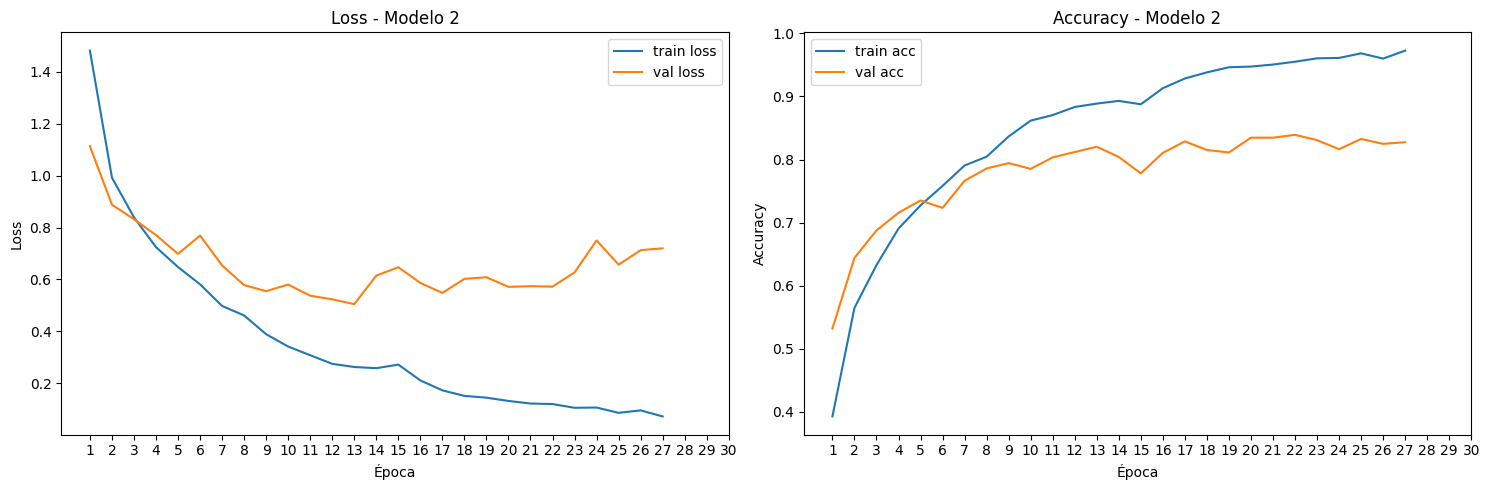

In [ ]:
plot_loss_accuracy(history2, title='Modelo 2')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


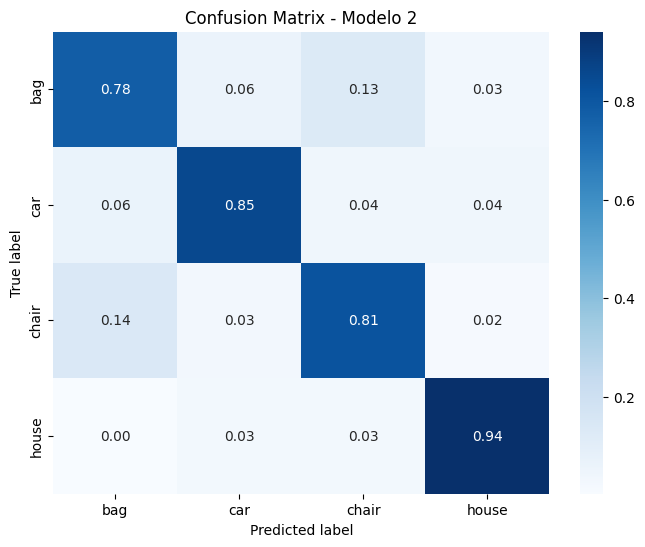

In [ ]:
plot_confusion_matrix(model2, val_ds, title='Modelo 2')

##### Discussão:

Para aumentar a complexidade do modelo, utilizamos mais camadas convolucionais, além de uma camada *fully connected* mais complexa no final do modelo. No primeiro modelo, utilizamos regularização dropout apenas na camada final, além de uma arquitetura ligeiramente mais complexa que o baseline, em especial na camada densa com 512 neurônios, antes da camada final com softmax. Estas mudanças aumentaram a acurácia para 75.5%, mas com um aumento de mais de 110x na quantidade de parâmetros e complexidade do modelo. No segundo modelo, apostamos no uso de mais técnicas de regularização (BatchNorm e Dropout), além de uma abordagem de redução de dimensionalidade mais agressiva, com uso de MaxPooling e convoluções com filtros maiores. Por fim, a camada densa também se beneficiou da redução de neurônios e separação em duas camadas. Estas modificações trouxeram uma redução do tamanho total do modelo (11x menos parâmetros), mas sua maior complexidade proporcionou uma melhoria considerável na acurácia de validação, agora em 83.9%.

### Treinamento com Arquitetura Pré-Treinada (ImageNet)

3. (1.5) Escolha uma arquitetura de rede neural que tenha sido pré-treinada na ImageNet e seja adequada para extração de características. Descarte a camada de saída original e congele todas as demais camadas da arquitetura. Em seguida, adicione uma nova camada de saída que corresponda ao número de classes específicas do problema. Prossiga com o treinamento apenas dessa nova camada.
Após concluir o treinamento, compare o desempenho dessa arquitetura com o melhor modelo que você desenvolveu anteriormente.


In [18]:
from keras.applications import MobileNetV2

m3_name = "model3"

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint_cb = ModelCheckpoint(
    filepath=build_checkpoint_file_name(m3_name),
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
NUM_CLASSES = 4

base_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

# congelando camadas convolucionais
for layer in base_model.layers:
    layer.trainable = False

model_pretrained = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(NUM_CLASSES, activation='softmax')  # 4 classes específicas
])

model_pretrained.compile(
    optimizer=tf.keras.optimizers.SGD(1e-2, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model_pretrained.summary()

/tmp/ipython-input-1899172966.py:22: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,299,108 (8.77 MB)

 Trainable params: 41,124 (160.64 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
history3 = train_or_load_model(model_pretrained, m3_name, epochs=30, callbacks=[checkpoint_cb, early_stopping])
model_pretrained.evaluate(val_ds)

Carregando dos arquivos drive/MyDrive/mdc_checkpoints/model3-history.json e drive/MyDrive/mdc_checkpoints/model3.keras


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 176ms/step - accuracy: 0.9769 - loss: 0.0720


[0.06595806032419205, 0.978515625]

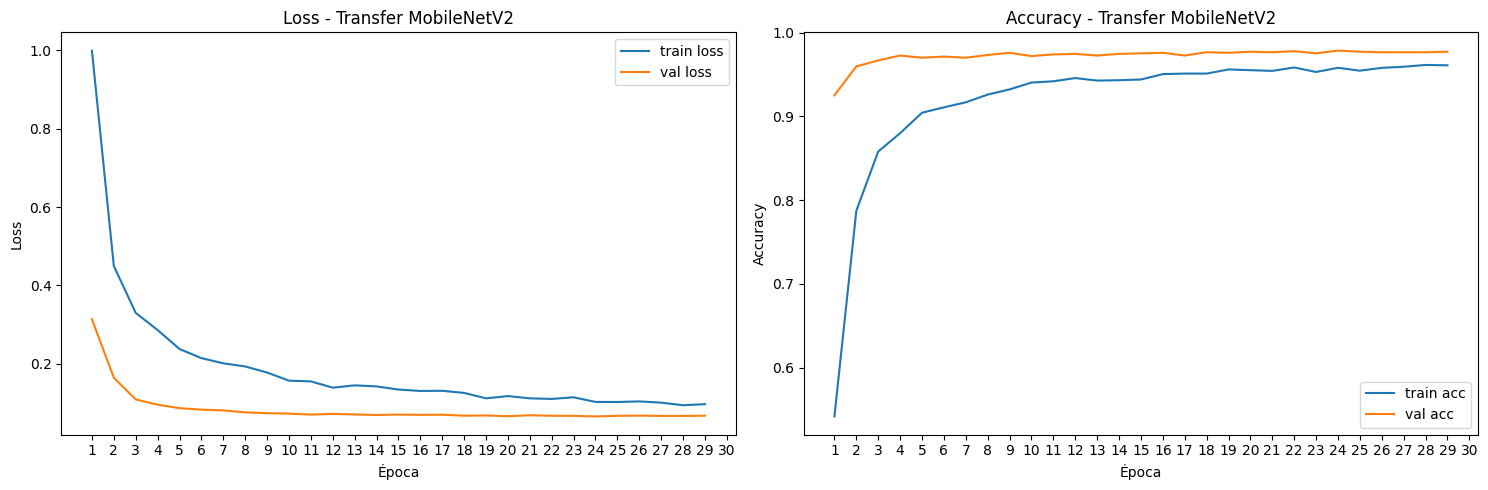

In [ ]:
plot_loss_accuracy(history3, title='Transfer MobileNetV2')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


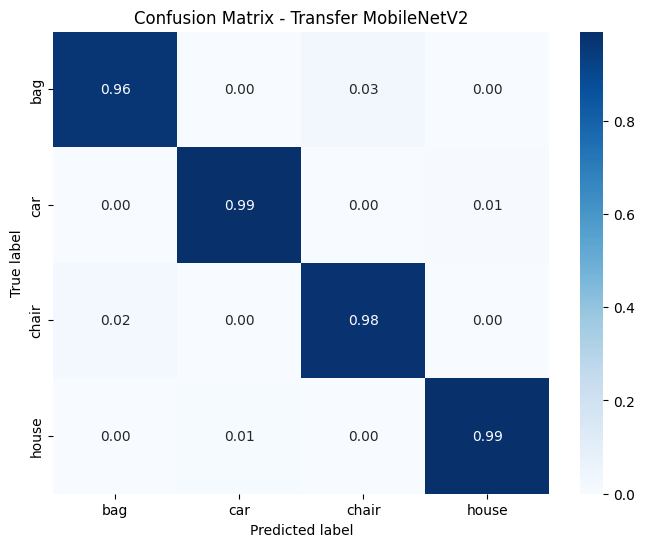

In [ ]:
plot_confusion_matrix(model_pretrained, val_ds, title='Transfer MobileNetV2')

Discussão:
Utilizamos o MobileNetV2 como modelo base. Ao remover todas as camadas de convolução desse modelo e aplicar um dropout de 0.6 e usar uma camada densa com 32 neurônios, conseguimos reverter o comportamente de overfitting que estava sendo observamos em todos os modelos até então construídos. Além disso, foi possível obter uma acurácia no conjunto de validação no valor de 0.9728, superior a todos os modelos treinados anteriormente para esse conjunto de dados.

### Ajuste Fino das Camadas de Extração de Características

4. (1.5) Usando a mesma arquitetura da questão anterior, descongele as camadas da rede responsáveis pela extração de características e realize o ajuste fino (fine-tuning) dessa parte do modelo junto com a nova camada de decisão. Em seguida, compare os novos resultados com os obtidos anteriormente, analisando detalhadamente as diferenças e identificando possíveis melhorias no desempenho. (Obs: Um novo modelo deve ser instanciado)



In [21]:
m4_name = "model4_finetuning.2"

# Callbacks: EarlyStopping e Checkpoint
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint_cb = ModelCheckpoint(
    filepath=build_checkpoint_file_name(m4_name),
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
NUM_CLASSES = 4

base_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

fine_tune_at = int(len(base_model.layers) * 0.95)
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
  layer.trainable = True

model_finetuned = tf.keras.Sequential([
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.6),
  layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compilação do modelo com o otimizador Adam
model_finetuned.compile(
    optimizer=tf.keras.optimizers.SGD(1e-2, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model_finetuned.summary()

/tmp/ipython-input-874069012.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,299,108 (8.77 MB)

 Trainable params: 771,684 (2.94 MB)

 Non-trainable params: 1,527,424 (5.83 MB)

In [22]:
history4 = train_or_load_model(model_finetuned,m4_name,epochs=30,callbacks=[checkpoint_cb, early_stopping])
model_finetuned.evaluate(val_ds)

Carregando dos arquivos drive/MyDrive/mdc_checkpoints/model4_finetuning.2-history.json e drive/MyDrive/mdc_checkpoints/model4_finetuning.2.keras


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 15 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9727 - loss: 0.1118


[0.10619533807039261, 0.9752604365348816]

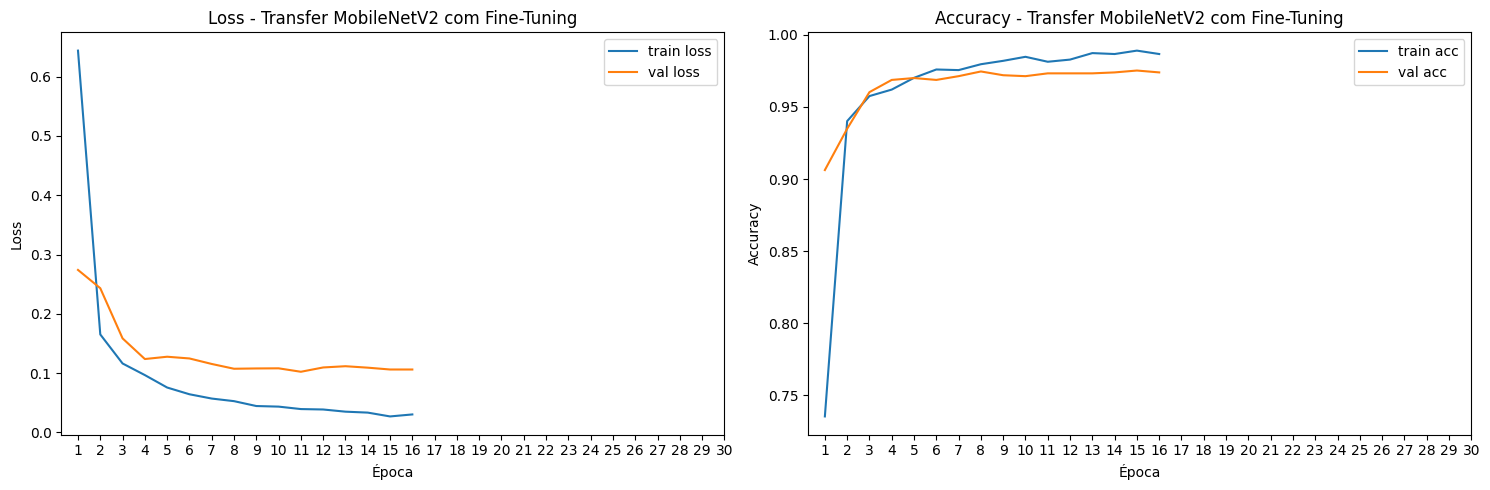

In [ ]:
plot_loss_accuracy(history4, title='Transfer MobileNetV2 com Fine-Tuning')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


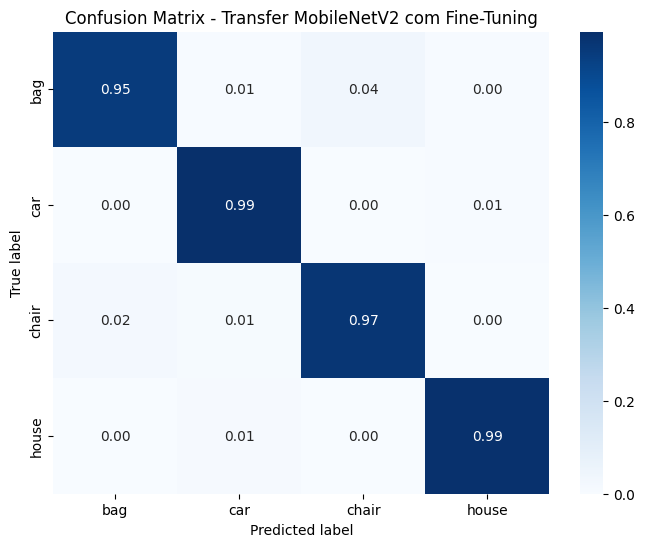

In [ ]:
plot_confusion_matrix(model_finetuned, val_ds, title='Transfer MobileNetV2 com Fine-Tuning')

Discussão:
Ao descongelar as camadas de convolução observamos que a acurácia no conjunto de treino melhorou, chegando a um valor maior que 0.9742. Porém, a acurácia no conjunto de dados de validação não acompanhou essa melhoria com a mesma intensidade. Assim foi possível observar um indício de existência de overfitting, pois a acurácia no conjunto de treino superou a do conjunto de validação.
Outro ponto a ser destacado é a "velocidade" com que a acurácia atingiu valores considerados bons para um modelo de classificação. Já na Época 3 podemos observar um valor próximo a 0,95 de acurácia no conjunto de treino.

### Seleção do Modelo com Melhor Acurácia Balanceada
5. (2.0) Selecione o modelo com a melhor acurácia balanceada e avalie-o utilizando o conjunto de teste. De forma clara e objetiva, destaque os principais desafios enfrentados durante o treinamento, explicando as estratégias adotadas para superá-los. Reflita também sobre a escolha dos hiperparâmetros, discutindo como essas decisões podem ter impactado o desempenho final do modelo.


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


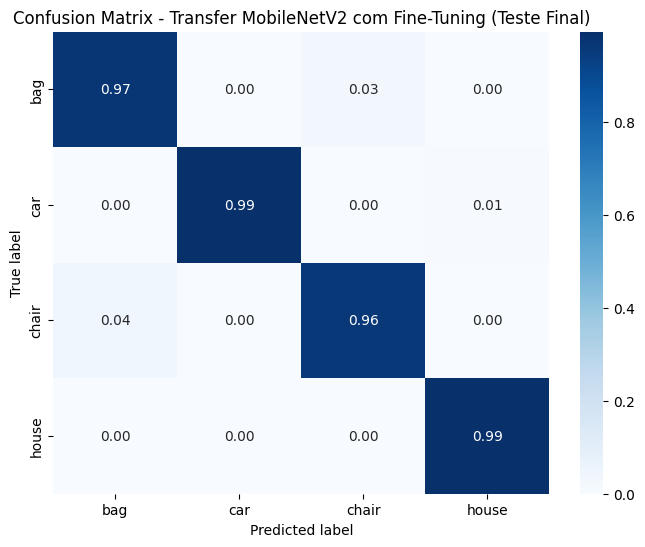

In [ ]:
plot_confusion_matrix(model_pretrained, test_ds, title='Transfer MobileNetV2 com Fine-Tuning (Teste Final)')

In [ ]:
model_pretrained.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 620ms/step - accuracy: 0.9788 - loss: 0.0694


[0.07265319675207138, 0.9770992398262024]

In [53]:
def collect_predictions(dataset, model):
    # y_true and image tensors in dataset order
    y_true, imgs = [], []
    for x, y in dataset.unbatch():
        imgs.append(x.numpy())
        y_true.append(int(y.numpy()))
    y_true = np.array(y_true)

    y_prob = model.predict(dataset, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    err_idx = np.where(y_true != y_pred)[0]

    return np.array(imgs)[err_idx], y_true[err_idx], len(y_true)

imgs, y_true, count = collect_predictions(test_ds, model_pretrained)

print(f"Total errors: {len(imgs)} / {count}")

Total errors: 36 / 1572


In [56]:
imgs_tf = tf.convert_to_tensor(imgs, dtype=tf.float32)
labels_tf = tf.convert_to_tensor(y_true, dtype=tf.int32)

new_ds = tf.data.Dataset.from_tensor_slices((imgs_tf, labels_tf))

new_ds = new_ds.batch(32)

test_preds = model_pretrained.predict(new_ds)[:5]
np.array(class_names)[np.argmax(test_preds, axis=1)]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array(['bag', 'bag', 'bag', 'bag', 'house'], dtype='<U5')

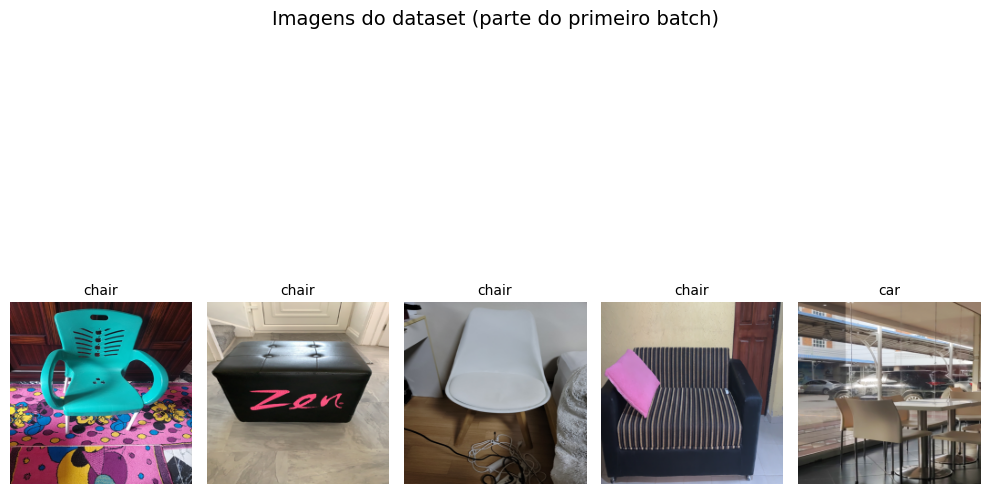

In [58]:
plot_denormalized_images(new_ds, n_row=1, n_col=5)

##### Discussão:

Um dos maiores desafios foi a rápida explosão no tamanho do modelo, conforme adicionamos camadas convolucionais. Mesmo com os modelos relativamente simples que implementamos, já atingimos próximo do limite de VRAM disponibilizado pelo ambiente do Colab. Para restringir o tamanho dos modelos, usamos camadas de Pooling, e buscamos ser o mais econômicos possível com as camadas densas, no final do modelo. Estas restrições, associadas a técnicas de regularização, conseguiram trazer bons resultados. Quanto aos hiperparâmetros, não realizamos uma busca sistemática ampla, mas dentre os testes feitos, o que trouxe maior diferença nos resultados foi a taxa de aprendizado do gradiente descendente estocástico. Esta taxa, associada ao momento, fez com que o aprendizado fosse acelerado e atingisse valores interessantes dentro do intervalo de 30 épocas. Como alternativas de melhoria, poderíamos ter explorado técnicas de adaptação da taxa de aprendizado durante o treinamento e mudanças no tamanho do Batch. O modelo de melhor performance foi o modelo diretamente pré-treinado com o MobileNetV2 que entregou 97.3% de acurácia na validação e 97.7% no teste final, até mesmo superando a validação no teste cego. Por fim, plotamos algumas das imagens onde o modelo errou no teste, e observamos ainda a tendência de confundir cadeiras com bolsas.

### Aplicação do Grad-CAM para Visualização de Classes

6. (2.0) Utilizando o modelo com a melhor acurácia balanceada, aplique a técnica de visualização Grad-CAM para cada classe do conjunto de dados. Para cada classe, escolha duas imagens: uma corretamente classificada e outra incorretamente classificada pelo modelo. Use o Grad-CAM para identificar as áreas das imagens que mais influenciaram as previsões do modelo. Descreva suas observações sobre as regiões destacadas e discuta suas conclusões a partir dessa análise.

- Abaixo esta declarado uma implementação do algoritmo Grad-CAM e um exemplo de uso.

#### O algoritmo Grad-CAM

In [59]:
from tensorflow import keras
import matplotlib as mpl

def get_img_array(img_path, size):
  '''
  Carrega uma imagem a partir de um endereço, transforma em um array e em um batch.
  Espera uma imagem colorida (3 canais).
  '''
  # `img` é uma imagem PIL de tamanho 299x299
  img = keras.utils.load_img(img_path, target_size=size)
  # `array` é um array Numpy float32 com forma (299, 299, 3)
  array = keras.utils.img_to_array(img)
  # Adicionamos uma dimensão para transformar nosso array em um "batch"
  # de tamanho (1, 299, 299, 3)
  array = np.expand_dims(array, axis=0)

  return array

def unwrap_model(model, last_conv_layer_name, base_model_name):
  '''
  Essa função extrai os outputs de um modelo aninhado dentro do modelo principal.
  Por exemplo: caso o modelo utilize uma resnet como extrator de características,
  se a ultima camada convolucional for do modelo da resnet, 'last_conv_layer_name'
  apenas será visível a partir do modelo aninhado.
  '''
  n_model = model.get_layer(base_model_name)
  n_model_conv_out = n_model.get_layer(last_conv_layer_name).output
  inp = n_model.input

  # Executa o resto da rede, supondo que o modelo base era a primeira camada
  other_layers = model.layers[1:]
  curr_out = n_model_conv_out
  for layer in other_layers:
    curr_out = layer(curr_out)

  return tf.keras.models.Model(inp, [n_model_conv_out, curr_out])

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, base_model_name=None):
  # Primeiro, criamos um modelo que mapeia a imagem de entrada para as ativações
  # da última camada convolucional, bem como as previsões de saída
  # Caso o modelo utilize um outro modelo pré treinado (fine-tunning), e sua ultima
  # camada convolucional esteja dentro deste modelo, usamos o parâmetro base_model_name
  # para criarmos o modelo do GradCAM.
  if  base_model_name is None:
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.layers[-1].output]
    )
  else:
    grad_model = unwrap_model(model, last_conv_layer_name, base_model_name)

  # Em seguida, computamos o gradiente da classe prevista no topo para nossa imagem de entrada
  # em relação às ativações da última camada convolucional
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # Este é o gradiente do neurônio de saída (mais previsto ou escolhido)
  # em relação ao mapa de características de saída da última camada convolucional
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # Este é um vetor onde cada entrada é a intensidade média do gradiente
  # sobre um canal específico do mapa de características
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # Multiplicamos cada canal no array do mapa de características
  # por "quão importante esse canal é" em relação à classe prevista no topo
  # e então somamos todos os canais para obter o mapa de calor de ativação da classe
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # Para fins de visualização, também normalizamos o mapa de calor entre 0 e 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

def denormalize_imagenet_image(normalized_img_np: np.ndarray) -> np.ndarray:
  """
  Reverses the ImageNet normalization process on a single image.
  Formula: original = (normalized * std) + mean

  Args:
      normalized_img_np: A NumPy array (H, W, C) with values normalized
                          using ImageNet mean/std.

  Returns:
      np.ndarray: The image array scaled to [0, 255] and cast to np.uint8.
  """
  # Reshape constants to (1, 1, 3) for broadcasting
  mean = IMAGENET_MEAN.numpy().reshape(1, 1, 3)
  std = IMAGENET_STD.numpy().reshape(1, 1, 3)

  # Reverse normalization: (normalized * std) + mean
  denormalized_img = (normalized_img_np * std) + mean

  # Rescale to [0, 255] and clip to handle minor floating point errors
  denormalized_img = np.clip(denormalized_img * 255.0, 0, 255)

  return denormalized_img.astype(np.uint8)

def show_heatmap_with_image(img, heatmap, alpha=0.5, denormalize_img=True):
  '''
  Mostra uma imagem junto de seu mapa de calor (heatmap).
  O parâmetro alpha controla a opacidade do mapa de calor.
  '''
  # Redimensionar o mapa de calor e imagem para o intervalo de 0 a 255
  heatmap = np.uint8(255 * heatmap)

  if denormalize_img:
    img = denormalize_imagenet_image(img)

  # Usar o mapa de cores 'jet' para colorir o mapa de calor
  jet = mpl.colormaps["jet"]

  # Usar os valores RGB do mapa de cores
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Criar uma imagem com o mapa de calor colorizado em RGB
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  # Sobrepor o mapa de calor na imagem original
  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)

  plt.figure(figsize=(12, 6))
  plt.imshow(superimposed_img, cmap="jet")
  plt.title("Grad-CAM Heatmap")
  plt.grid(False)
  plt.axis('off')
  plt.colorbar()
  plt.show()

#### Exemplo de Visualização de Ativações de Classe com Grad-CAM

##### Parâmetros configuráveis
Esses parâmetros devem ser alterados para o seu modelo.

Para obter os valores de last_conv_layer_name, utilize o comando model.summary(), que exibirá os nomes de todas as camadas do modelo.

In [ ]:
from IPython.display import Image, display

model_builder = keras.applications.xception.Xception
img_size = (IMAGE_HEIGHT, IMAGE_WIDTH)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# img_path = keras.utils.get_file(
#     "african_elephant.jpg",
#     "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSFnDnhqw5kPYKQ8g0lmNj6N-lpRTbyo_tJhw&s"
# )

# display(Image(img_path))


def collect_predictions(dataset, model, true=True):
    # y_true and image tensors in dataset order
    y_true, imgs = [], []
    for x, y in dataset.unbatch():
        imgs.append(x.numpy())
        y_true.append(int(y.numpy()))
    y_true = np.array(y_true)

    y_prob = model.predict(dataset, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    if true:
        err_idx = np.where(y_true == y_pred)[0]
    else:
      err_idx = np.where(y_true != y_pred)[0]

    return np.array(imgs)[err_idx], y_true[err_idx], len(y_true)



imgs_true, y_true_true, count = collect_predictions(test_ds, model_pretrained, True)
imgs_tf = tf.convert_to_tensor(imgs_true, dtype=tf.float32)
labels_tf = tf.convert_to_tensor(y_true_true, dtype=tf.int32)

new_ds_true = tf.data.Dataset.from_tensor_slices((imgs_tf, labels_tf))

new_ds_true = new_ds_true.batch(32)

imgs_false, y_true_false, count = collect_predictions(test_ds, model_pretrained, False)
imgs_tf = tf.convert_to_tensor(imgs_false, dtype=tf.float32)
labels_tf = tf.convert_to_tensor(y_true_false, dtype=tf.int32)

new_ds_false = tf.data.Dataset.from_tensor_slices((imgs_tf, labels_tf))

new_ds_false = new_ds_false.batch(32)

print(f"Total errors: {len(imgs)} / {count}")


def build_grad_cam_inputs(dss):
  # pega o primeiro batch
  first_batch_images, first_batch_labels = next(iter(dss))
  # pega primeira imagem
  sample_img = first_batch_images[0]
  sample_label = first_batch_labels[0]
  # transforma para numpy
  sample_img_np = sample_img.numpy()
  sample_label_np = sample_label.numpy()
  # Adiciona uma dimensão "vazia" para ficar no formato que o modelo espera (batch_size, width, height, channels)
  return np.expand_dims(sample_img_np, axis=0)


In [67]:
img_false = build_grad_cam_inputs(new_ds_false)[0]
img_true = build_grad_cam_inputs(new_ds_true)[0]

In [69]:

img_false.shape

(200, 200, 3)

##### Executando o algoritmo gradcam e visualizando o resultado

In [72]:
# Preparar a imagem
# img_array = preprocess_input(get_img_array(img_false, size=img_size))
img_array = preprocess_input(img_true)
# img_array = tf.convert_to_tensor(preprocess_input(get_img_array(img_path, size=img_size)))

# Construir o modelo
Xception_model = model_builder(weights="imagenet")

# Remover a função softmax da última camada
# Xception_model.layers[-1].activation = None

# Imprimir qual é a classe prevista no topo
preds = Xception_model.predict(img_array)
print("Previsto:", decode_predictions(preds, top=1)[0])

# Converte para tensor para evitar warnings do Keras
# img_array = tf.convert_to_tensor([img_array])

# Gerar o mapa de calor de ativação da classe
heatmap = make_gradcam_heatmap(
    [img_array],
    Xception_model,
    last_conv_layer_name)

# Isso também poderia ser feito de outra forma como:
# heatmap = make_gradcam_heatmap(
#     input_batch,
#     model,
#     last_conv_layer_name,  # Nome da ultima camada convolucional específicamente
#     base_model_name # nome do modelo "base", caso seja um modelo de transfer learning com modelo,
#                                               avg pooling (ou flatten) e uma camada de ativacao
# )

# Exibir o mapa de calor
plt.matshow(heatmap)
plt.grid(False)
plt.axis('off')
plt.show()


ValueError: Input 0 of layer "xception" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(32, 200, 3)

In [ ]:
heatmap.shape

(10, 10)

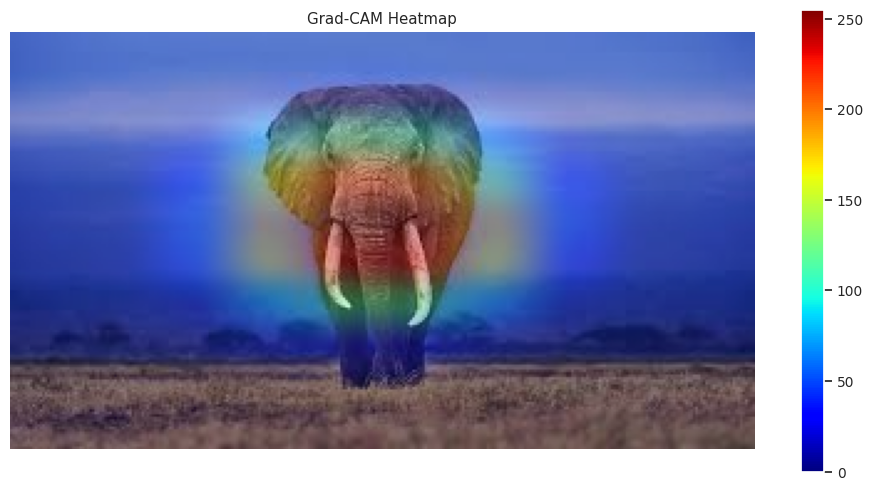

In [ ]:
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

show_heatmap_with_image(img, heatmap, denormalize_img=False)

#### Agora é sua vez ...


Discussão: